In [226]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [229]:
import os 
os.system("python3 main_traj.py --periods 2 --ppp 1000")

0

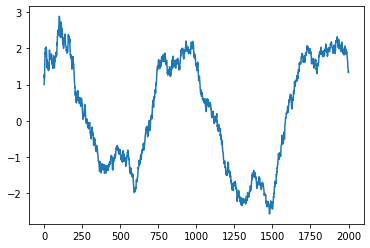

In [230]:
from misc import load_data, get_def_path

periods = 2
ppp=1000
train_id = 0
defpath = get_def_path()
path = defpath+"{}periods/{}ppp/".format(periods,ppp)
means, covs, signals, coeffs = load_data(path)
tfsignals = tf.convert_to_tensor(signals)[tf.newaxis]
A,dt,C,D = coeffs
times = np.linspace(0,periods, periods*ppp+1)
total_time = times[-1]
plt.plot(means[:,0])

In [231]:
from visual_model import *

In [232]:
rmodel = GRNNmodelVisual(coeffs = [C,D,dt, total_time], traj_details=[periods, ppp, train_id, path], cov_in=tf.convert_to_tensor(covs[0].astype(np.float32)), stateful=False)
rmodel.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01))
rmodel.recurrent_layer(tfsignals[:,:10,:], initial_state=rmodel.initial_state)
#rmodel.trainable_variables[0].assign(tf.convert_to_tensor(A.astype(np.float32)))

<tf.Tensor: shape=(1, 10, 2), dtype=float32, numpy=
array([[[ 0.002     ,  0.        ],
        [ 0.0022    , -0.0002    ],
        [ 0.00202602, -0.0004    ],
        [ 0.00222602, -0.0006    ],
        [ 0.00242602, -0.0008    ],
        [ 0.00253866, -0.00089048],
        [ 0.00273866, -0.00109048],
        [ 0.00264559, -0.00122773],
        [ 0.00284559, -0.00142773],
        [ 0.00280269, -0.00162773]]], dtype=float32)>

In [195]:
parameters = np.arange(0,4*np.pi+np.pi/2,np.pi/2)

In [201]:
rmodel.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[2*np.pi]]).astype(np.float32)))
tr = rmodel(tfsignals)


In [240]:
loss_values = {}

for length_series in [len(signals)]:

    l={}
    for th in tqdm(parameters):
        #rmodel.recurrent_layer.reset_states(states=rmodel.initial_state)
        rmodel.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[th]]).astype(np.float32)))
        dy = tfsignals[:,:length_series,:]
        tr = rmodel(dy)
        diff = (tr - tfsignals)[0]
        l[th] = np.sum(tf.einsum('bj,bj->b',diff,diff))/2
    loss_values[length_series] = np.array(list(l.values()))


100%|██████████| 9/9 [00:29<00:00,  3.32s/it]


2.0

Text(0.5, 1.0, '$\\omega = $6.28')

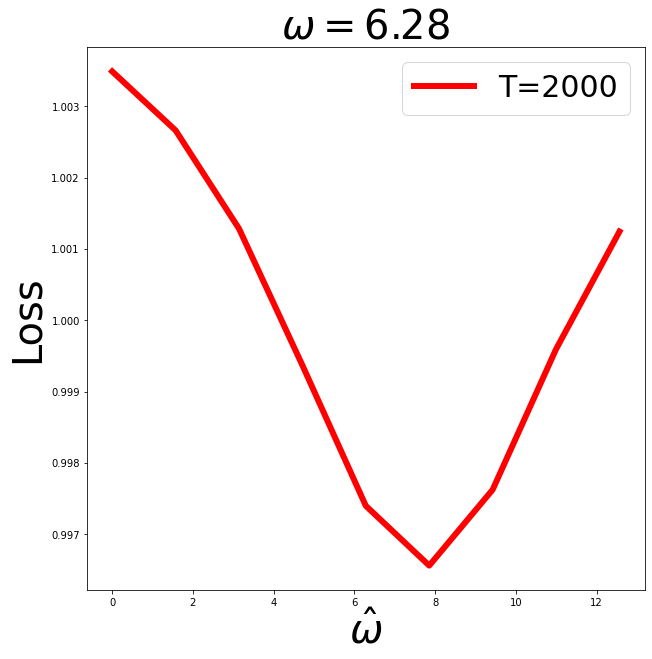

In [246]:
plt.figure(figsize=(10,10))
for ind,length_series in enumerate(list(loss_values.keys())):
    plt.plot(parameters,loss_values[length_series]/total_time, label="T=" + str(length_series), color=["red","blue","green"][ind], linewidth=6)
plt.xlabel(r'$\hat{\omega}$', size=40)
plt.ylabel("Loss",size=40)
plt.legend(prop={'size':30})
plt.title(r'$\omega = $'+str(np.round(2*np.pi,2)),size=40)
#plt.xticks(ticks=parameters, labels=[np.round(k,2) for k in parameters])